In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output, Audio
import dataloader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ipywidgets import interactive
import circularPitchSpace as cps
import matplotlib.gridspec as gridspec
import features

%matplotlib inline

dataset = None

def update_dropdown_id_options(*args):
    global dataset
    selected_split = dropdown_split.value
    dataset = dataloader.MIRDataset("beatles", use_deep_chroma=True, align_chroma=False, split_nr=selected_split)
    dropdown_id.options = list(dataset.getTrackList().keys())
    dropdown_id.value = list(dataset.getTrackList().keys())[0]  # Set the default value

def update_selected_track_id(*args):
    selected_track_id = dataset.getTrackList()[dropdown_id.value]
    textbox_track_id.value = selected_track_id
    

# Create the dropdown widgets
dropdown_split = widgets.Dropdown(
    options=[1, 2, 3, 4, 5, 6, 7],
    value = 3,
    description='Split:',
    disabled=False,
)

dropdown_id = widgets.Dropdown(
    description='Track ID:',
    disabled=False,
)

textbox_track_id = widgets.Text(
    description='Selected Track ID:',
    disabled=True,
)
update_dropdown_id_options()
update_selected_track_id()
# Register the event handlers
dropdown_split.observe(update_dropdown_id_options, 'value')
dropdown_id.observe(update_selected_track_id, 'value')

# Display the widgets
display(dropdown_split, dropdown_id, textbox_track_id)


Dropdown(description='Split:', index=2, options=(1, 2, 3, 4, 5, 6, 7), value=3)

Dropdown(description='Track ID:', options=('0101', '0104', '0209', '0306', '0308', '0401', '0408', '0506', '06…

Text(value='01_-_I_Saw_Her_Standing_There', description='Selected Track ID:', disabled=True)

load features for selected audiofile

In [5]:
feature_processor = features.FeatureProcessor(dropdown_split.value)
audiopath,target = dataset[dropdown_id.value]
ref_intervals, ref_labels = target
t_deep_chroma,deep_chroma = feature_processor.deepChroma(audiopath,beat_alignment=True)
t_clp_chroma,clp_chroma = feature_processor.clpChroma(audiopath,beat_alignment=True)
t_librosa_chroma, librosa_chroma = feature_processor.librosaChroma(audiopath,normalize=True,beat_alignment=True) # transpose chroma

find out wich key is most suited for chord recognition with the pitch space model

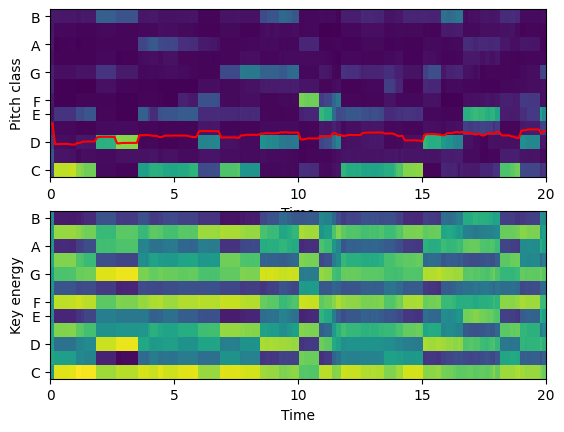

In [6]:
import librosa.display
chroma = librosa_chroma
t = t_librosa_chroma
chroma_energy = np.zeros_like(chroma,dtype=float)
for time_index in range(chroma.shape[0]):
    # calculte key related circles
    for x in cps.pitch_classes:
        n_k = x.num_accidentals
        # iterate over all chroma bins with correct index
        for i,pitch_class in enumerate(cps.pitch_classes):
            n_f = cps.sym3(49*pitch_class.chromatic_index,84,7*n_k)
            # check if real pitch is part of the key n_k
            if cps.checkIndex(n_f,n_k):
                chroma_energy[time_index,x.pitch_class_index] += chroma[time_index,i]
correlation = np.matmul(chroma_energy,cps.createKeyTemplate())
fig,ax = plt.subplots(2,1)
librosa.display.specshow(chroma.T,cmap="viridis", y_axis="chroma",
                             ax=ax[0], x_axis='time', sr=44100, hop_length=4410)
ax[0].plot(t,feature_processor.entropy(chroma),'r')
librosa.display.specshow(correlation.T,cmap="viridis", y_axis="chroma",
                             ax=ax[1], x_axis='time', sr=44100, hop_length=4410)
ax[1].set_ylabel("Key energy")
for x in ax:
    x.set_xlim(0,20)

key_estimate = np.argmax(correlation,axis=1)


In [1]:
x_F,x_FR,x_TR,x_DR = cps.transformChroma(chroma)
entropy = feature_processor.entropy(chroma)
labels=[]
templates,template_labels = cps.createChordTemplates()
for j in range(chroma.shape[0]):
    # measure distance to each angle in the two circles
    distance = np.zeros((7,),dtype=float)
    pitch_class_index = key_estimate[j]
    r_F,r_FR,r_TR,r_DR = cps.transformChroma(templates[pitch_class_index,:,:])
    for i in range(7): # for C-major templates
        d_F = cps.calculateDistance(x_F[j],r_F[i])
        d_FR = cps.calculateDistance(x_FR[j,pitch_class_index],r_FR[i,pitch_class_index])
        d_TR = cps.calculateDistance(x_TR[j,pitch_class_index],r_TR[i,pitch_class_index])
        d_DR = cps.calculateDistance(x_DR[j,pitch_class_index],r_DR[i,pitch_class_index])
        distance[i] = d_FR + d_TR
    labels.append(template_labels[pitch_class_index][np.argmin(distance)])

# calculate chord intervals
intervals = []
est_labels = []
t_start = 0
for i,(label_t0,label_t1) in enumerate(zip(labels[:-1],labels[1:])):
    if label_t0 != label_t1: # potential chord change
            est_labels.append(label_t0)
            intervals.append([t_start,t[i]])
            t_start = t[i+1]
# skip false chord changes
est_intervals = np.array(intervals)
# Initialize the range slider with the minimum and maximum time values
t_max_init = t[-1]

def plotVector(ax, z):
    def getAlpha(i,n_points):
        k = (1-0.2)/n_points
        return k*i +0.2
    
    for i in range(len(z)):
        ax.plot(z[i].real,z[i].imag, 'o', color="b",alpha = getAlpha(i,len(z)), markersize=2)
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)

def plotCpsPrediction(fig, gs, chroma, est_intervals, est_labels, start_time, stop_time):
    r_F,r_FR,r_TR,r_DR = cps.transformChroma(chroma)
    row_index = 1
    for interval,label in zip(est_intervals,est_labels):
        # skip intervals that are out of range
        if interval[0] < start_time and interval[1] < start_time:
            continue
        if interval[0] > stop_time and interval[1] > stop_time:
            continue
        
        # set frame index
        start_index = int(max(interval[0], start_time) * 10)
        stop_index = int(min(interval[1], stop_time) * 10)

        # add axes to grid and plot CPS circles
        ax0 = fig.add_subplot(gs[row_index, 0])
        ax0.axis("off")
        ax1 = fig.add_subplot(gs[row_index, 1])
        ax2 = fig.add_subplot(gs[row_index, 2])
        ax3 = fig.add_subplot(gs[row_index, 3])
        ax4 = fig.add_subplot(gs[row_index, 4])
        row_index += 1
        pitch_class_index = key_estimate[start_index]
        cps.plotCircleOfFifths(ax1)
        cps.plotCircleOfFifthsRelated(ax2, pitch_class_index)  
        cps.plotCircleOfThirdsRelated(ax3,pitch_class_index)
        cps.plotCircleOfDiatonicRelated(ax4,pitch_class_index)

        ax0.text(0.5,0.5,f"{label}")
        ax0.text(0.5,0.3,f"{round(max(interval[0], start_time),1)}-{round(min(interval[1], stop_time),1)}")
        plotVector(ax1,r_F[start_index:stop_index]*1j)
        plotVector(ax2, r_FR[start_index:stop_index, pitch_class_index]*1j)
        plotVector(ax3,r_TR[start_index:stop_index,pitch_class_index]*1j)
        plotVector(ax4,r_DR[start_index:stop_index,pitch_class_index]*1j)

def plotChordPrediction(t_min, t_max,t_index,t_delta):
    fig = plt.figure(figsize=(8,4*8))
    gs = gridspec.GridSpec(20, 5)
    ax = fig.add_subplot(gs[0, :])

    for i, label in enumerate(ref_labels):
        if t_min <= ref_intervals[i, 0] < t_max:
            ax.vlines(ref_intervals[i, 0], -0.5, 11.5, 'grey', linestyles='dashed', linewidth=1)
            ax.text(ref_intervals[i, 0], 12.5, label, fontsize=6, horizontalalignment='center')

    for i, label in enumerate(est_labels):
        if t_min <= est_intervals[i, 0] < t_max:
            ax.vlines(est_intervals[i, 0], -0.5, 11.5, 'r', linestyles='dashed', linewidth=1)
            ax.text(est_intervals[i, 0], 14, label, fontsize=6, horizontalalignment='center', color='r')

    ax.vlines(t_index, -0.5, 11.5, 'blue')  # yellow vertical line controlled by the slider
    start_time = max(0, t_index - t_delta/2)
    stop_time = min(t_index + t_delta/2, chroma.shape[0]*0.1)
    width = stop_time - start_time
    rect = patches.Rectangle((start_time, -0.5), width, 12,facecolor="none",alpha=0.8, edgecolor='b')

    # Add the rectangular patch to the plot
   
    librosa.display.specshow(chroma.T,cmap="Reds", y_axis="chroma",
                             ax=ax, x_axis='time', sr=44100, hop_length=4410)
    ax.set_xlabel("")
    ax.add_patch(rect)


    for col in range(2):
        ax.set_xlim((t_min, t_max))

    plotCpsPrediction(fig, gs, chroma, est_intervals, est_labels, start_time, stop_time)
    # plotWaveform(fig,gs,t_min,t_max,chroma_index)
    plt.show()


range_slider = widgets.FloatRangeSlider(
    value=[0, 20],
    min=0, max=t_max_init, step=5,
    description='Time Range:',
    readout_format='.1f',
)

t_index_slider = widgets.FloatSlider(
    value=10,
    min=0, max=t_max_init, step=0.1,
    description='Time (sec):',
    readout_format='.1f',
)

t_delta_slider = widgets.IntSlider(
    value=5,
    min=0, max=t_max_init, step=1,
    description='Time span (sec):'
)

def updateTIndexSlider(*args):
    t_index_slider.min = range_slider.value[0]
    t_index_slider.max = range_slider.value[1]
    t_delta_slider.min = 1
    t_delta_slider.max = range_slider.value[1]-range_slider.value[0]

def updatePlot(t_range,t_index,t_delta):
    t_min, t_max = t_range
    clear_output(wait=True)
    plotChordPrediction(t_min, t_max, t_index,t_delta)

updateTIndexSlider()

range_slider.observe(updateTIndexSlider, 'value')
interactive_plot = interactive(updatePlot, t_range=range_slider, t_index=t_index_slider, t_delta=t_delta_slider)
output = interactive_plot.children[-1]
output.layout.height = '500'
display(interactive_plot)


NameError: name 'cps' is not defined

In [ ]:
# complexity feature für akkorde
# 1.) Sum of chroma differences
# 2.) shannon entropy , usw..

Akkordanalyse